In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output
import matplotlib.pyplot as plt
import pathlib

In [2]:
tf.__version__, tf.executing_eagerly()

('2.6.0', True)

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14168868252974180704
]


2021-11-02 12:25:05.094803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 12:25:05.099600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-02 12:25:05.099659: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 12:25:05.099700: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (k234): /proc/driver/nvidia/version does not exist


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [12]:
tf.debugging.set_log_device_placement(False)

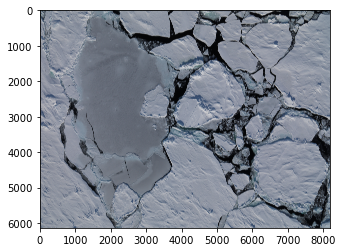

In [8]:
# load data
img = tf.keras.utils.load_img('../data/Testing/Inputs/testing_71.jpg')
plt.imshow(img)

In [9]:
imga = tf.keras.utils.img_to_array(img)
imga.shape

(6132, 8176, 3)

In [7]:
# (25*9)**2/(25*5)
im = np.arange(225**2)%(625)==0
top = np.where(im==True)[0]//225 # gives the top values
left = np.where(im==True)[0]%225
top, left, 225**2/(625)*30, 625*3, len(top)*len(left)

(array([  0,   2,   5,   8,  11,  13,  16,  19,  22,  25,  27,  30,  33,
         36,  38,  41,  44,  47,  50,  52,  55,  58,  61,  63,  66,  69,
         72,  75,  77,  80,  83,  86,  88,  91,  94,  97, 100, 102, 105,
        108, 111, 113, 116, 119, 122, 125, 127, 130, 133, 136, 138, 141,
        144, 147, 150, 152, 155, 158, 161, 163, 166, 169, 172, 175, 177,
        180, 183, 186, 188, 191, 194, 197, 200, 202, 205, 208, 211, 213,
        216, 219, 222]),
 array([  0, 175, 125,  75,  25, 200, 150, 100,  50,   0, 175, 125,  75,
         25, 200, 150, 100,  50,   0, 175, 125,  75,  25, 200, 150, 100,
         50,   0, 175, 125,  75,  25, 200, 150, 100,  50,   0, 175, 125,
         75,  25, 200, 150, 100,  50,   0, 175, 125,  75,  25, 200, 150,
        100,  50,   0, 175, 125,  75,  25, 200, 150, 100,  50,   0, 175,
        125,  75,  25, 200, 150, 100,  50,   0, 175, 125,  75,  25, 200,
        150, 100,  50]),
 2430.0,
 1875,
 6561)

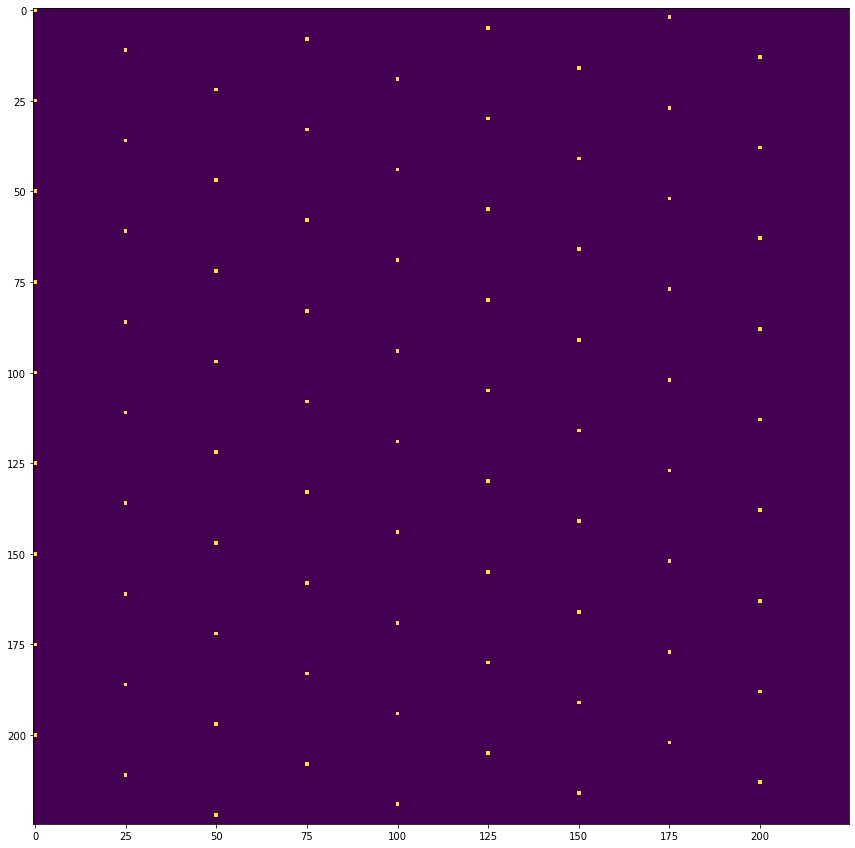

In [11]:
im = np.reshape(im, [225,225])
plt.subplots(figsize=(15,15))
plt.imshow(im)

In [5]:
# intialisation parameters
NUM_IMGS = 30
IMG_SHAPE = (764, 1020, 3)
MODEL_INP_SIZE = 224 #tf.constant(224, dtype=tf.dtypes.int32) # image of 224X224X3 channels
BATCH_SIZE = NUM_IMGS
STEPS_PER_EPOCH = 81 # same as the number of images in validation batch. So total number of images in an epoch is the same in validation and training
                     # int((MODEL_INP_SIZE+1)**2/BATCH_SIZE) # too many steps, leading to overfitting

In [6]:
f'percentage of image used for validation: {round((2*MODEL_INP_SIZE)**2/(IMG_SHAPE[0]*IMG_SHAPE[1])*100,2)}%', f'steps_per_epoch: {STEPS_PER_EPOCH}'

('percentage of image used for validation: 25.76%', 'steps_per_epoch: 81')

In [7]:
# generator to pass to tf.data.Dataset.from_generator()
def loadimggen():
    input_dir = pathlib.Path('../data/Testing/Inputs/')
    filenames = (p.stem for p in input_dir.glob('*.jpg'))
    print()
    print('Reading input images')
    for f in filenames:
        # print(input_dir.joinpath(f+'.jpg'))
        inp = tf.keras.utils.load_img(input_dir.joinpath(f+'.jpg'),target_size=IMG_SHAPE)
        # print(input_dir.parent.joinpath('Outputs',f+'.png'))
        out =  tf.keras.utils.load_img(input_dir.parent.joinpath('Outputs',f+'.png'),color_mode='grayscale',target_size=(764, 1020, 1))
        yield inp, out

In [56]:
def load_img(infile, outfile):
    print(f'input image: {infile} \noutput image: {outfile}')
    inp = tf.keras.utils.load_img(infile,target_size=IMG_SHAPE)
    out = tf.keras.utils.load_img(outfile,color_mode='grayscale',target_size=IMG_SHAPE)
    return inp, out

inputdataset = tf.data.Dataset.list_files("../data/Testing/Inputs/*.jpg", shuffle=False)
outputdataset = tf.data.Dataset.list_files("../data/Testing/Outputs/*.png", shuffle=False)
dataset = tf.data.Dataset.zip((inputdataset, outputdataset))
# list(dataset.take(1).map(load_img))
# dataset = tf.data.Dataset.zip((dataset.map(load_input_img, num_parallel_calls=True, deterministic=True),
                               # dataset.map(load_output_img, num_parallel_calls=True, deterministic=True)))

In [8]:
# random number generator
rng =  tf.random.Generator.from_seed(1727) #np.random.default_rng(42)

# function to extract random images for training dataset from each image
def generate_train(inp, out):
    # inp, out = inp_out
    # random translation and cropping
    top = rng.uniform([], minval=0, maxval=IMG_SHAPE[0]-MODEL_INP_SIZE, dtype=tf.dtypes.int32) #rng.integers(low=0, high=IMG_SHAPE[0]-MODEL_INP_SIZE)
    left = rng.uniform([], minval=0, maxval=IMG_SHAPE[1]-MODEL_INP_SIZE, dtype=tf.dtypes.int32) #rng.integers(low=0, high=IMG_SHAPE[1]-MODEL_INP_SIZE)
    while (top >= IMG_SHAPE[0]-2*MODEL_INP_SIZE and left >= IMG_SHAPE[1]-2*MODEL_INP_SIZE):
        top = rng.uniform([], minval=0, maxval=IMG_SHAPE[0]-MODEL_INP_SIZE, dtype=tf.dtypes.int32) #rng.integers(low=0, high=IMG_SHAPE[0]-MODEL_INP_SIZE)
        left = rng.uniform([], minval=0, maxval=IMG_SHAPE[1]-MODEL_INP_SIZE, dtype=tf.dtypes.int32) #rng.integers(low=0, high=IMG_SHAPE[1]-MODEL_INP_SIZE)
    inp = tf.image.crop_to_bounding_box(inp, top, left, MODEL_INP_SIZE, MODEL_INP_SIZE)
    out = tf.expand_dims(out, -1)
    out = tf.image.crop_to_bounding_box(out, top, left, MODEL_INP_SIZE, MODEL_INP_SIZE)
    # random flip (horizontal and vertical)
    hflip = rng.uniform([])
    vflip = rng.uniform([])
    if (hflip >= 0.5):
        inp = tf.image.flip_left_right(inp)
        out = tf.image.flip_left_right(out)
    if (vflip >= 0.5):
        inp = tf.image.flip_up_down(inp)
        out = tf.image.flip_up_down(out)
    return inp, out

# function to extract non-random validation images from each image and return in batches
def generate_val(inp, out):
    # inp, out = inp_out
    # c = tf.cast(counter[0]//NUM_IMGS, dtype=tf.int32)
    out = tf.expand_dims(out, -1)
    inplist = []
    outlist = []
    # subsample and take only every 625th index
    ind = np.arange((MODEL_INP_SIZE+1)**2)%625==0
    tind = np.where(ind==True)[0]//(MODEL_INP_SIZE+1) 
    lind = np.where(ind==True)[0]%(MODEL_INP_SIZE+1)
    for i, t in enumerate(tind):
        top = IMG_SHAPE[0]-2*MODEL_INP_SIZE+t
        left = IMG_SHAPE[1]-2*MODEL_INP_SIZE+lind[i]
        inplist.append(tf.image.crop_to_bounding_box(inp, top, left, MODEL_INP_SIZE, MODEL_INP_SIZE))
        outlist.append(tf.image.crop_to_bounding_box(out, top, left, MODEL_INP_SIZE, MODEL_INP_SIZE))
    return tf.stack(inplist), tf.stack(outlist)


In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask / 255
    return input_image, input_mask

In [10]:
dataset = tf.data.Dataset.from_generator(loadimggen,output_types=(tf.int32, tf.int32), output_shapes=(IMG_SHAPE, (764, 1020)))
# counter = tf.data.experimental.Counter()
# dataset = tf.data.Dataset.zip((dataset, counter))
train_dataset = (
    dataset
    .map(normalize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    .map(generate_train, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    .cache()
    .shuffle(NUM_IMGS)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))
val_dataset = (
    dataset
    .map(normalize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    .map(generate_val, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE))
tf.data.experimental.cardinality(train_dataset).numpy() # doesn't work when dataset is generated from files

-1

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2021-10-28 14:39:17.751291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Reading input images


2021-10-28 14:39:28.380724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 30
2021-10-28 14:39:37.908754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 30
2021-10-28 14:39:43.626945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


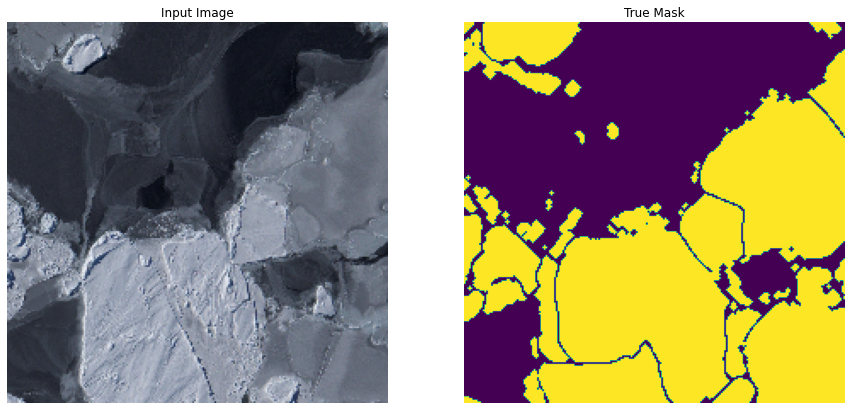

(30, 224, 224, 3) (30, 224, 224, 1)


In [27]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    # print(sample_image.shape, sample_mask.shape)
    print(images.shape, masks.shape)

2021-11-01 10:03:07.621037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Reading input images


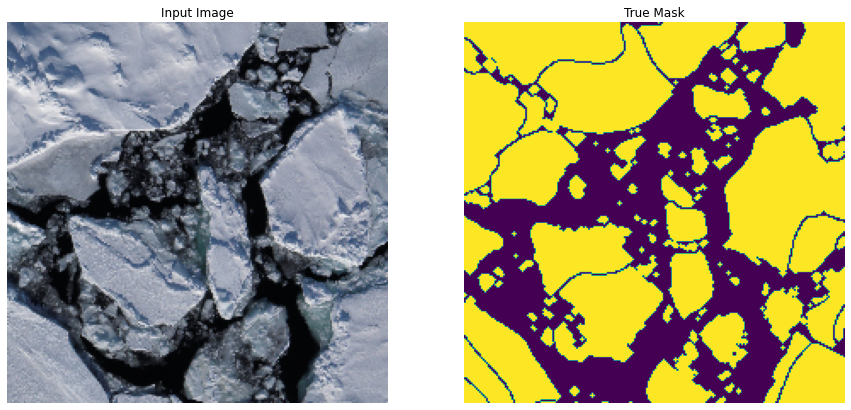

(81, 224, 224, 3) (81, 224, 224, 1)


2021-11-01 10:03:09.459837: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
for inp, out in val_dataset.take(1):
    sample_image, sample_mask = inp[0], out[0]
    display([sample_image, sample_mask])
    print(inp.shape, out.shape)

In [153]:
# custom metric to count the number of TrueNegatives
class TrueNegativeRate(tf.keras.metrics.Metric):
    def __init__(self, name='true_negative_rate', **kwargs):
        super(TrueNegativeRate, self).__init__(name=name, **kwargs)
        self.true_negative_rate = self.add_weight(name='tnr', initializer='zeros')
        self.TrueNegatives = tf.keras.metrics.TrueNegatives()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_mask = tf.argmax(y_pred, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        # print(y_true.shape, pred_mask.shape) # some shape debugging; ignore
        self.TrueNegatives.update_state(y_true, pred_mask)
        num_tn = self.TrueNegatives.result()
        # print(y_true.dtype)
        num_n = tf.math.reduce_sum(1. - y_true)
        # print(num_tn.numpy()/(81*224*224), num_n.numpy()/(81*224*224))
        Neg_acc=num_tn/tf.cast(num_n, tf.float32)
        self.true_negative_rate.assign(Neg_acc)
        
    def result(self):
        return self.true_negative_rate
    
    def reset_state(self):
        self.true_negative_rate.assign(0.)

In [154]:
m = TrueNegativeRate()
for inp, out in val_dataset.take(10):
    # sample_image, sample_mask = inp[0], out[0]
    # display([sample_image, sample_mask])
    # print(inp.shape, out.shape)
    pred =  model.predict(inp)
    m.update_state(out, pred)
    print(m.result())

# sample_pred = model.predict(sample_image[tf.newaxis, ...])
# m = TrueNegativeRate()
# m.update_state(sample_mask[tf.newaxis, ...], sample_pred)
# m.result()

<dtype: 'float64'>
tf.Tensor(0.47070783, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(0.7058185, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(0.8561056, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(2.2827663, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(0.79765147, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(5.363677, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(5.3260965, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(3.2440498, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(5.282799, shape=(), dtype=float32)
<dtype: 'float64'>
tf.Tensor(13.8990555, shape=(), dtype=float32)


In [13]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [150]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [15]:
up_stack = [
    upsample(512, 3, apply_dropout=True),  # 4x4 -> 8x8
    upsample(256, 3, apply_dropout=True),  # 8x8 -> 16x16
    upsample(128, 3, apply_dropout=True),  # 16x16 -> 32x32
    upsample(64, 3, apply_dropout=True),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [79]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', TrueNegativeRate()])

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

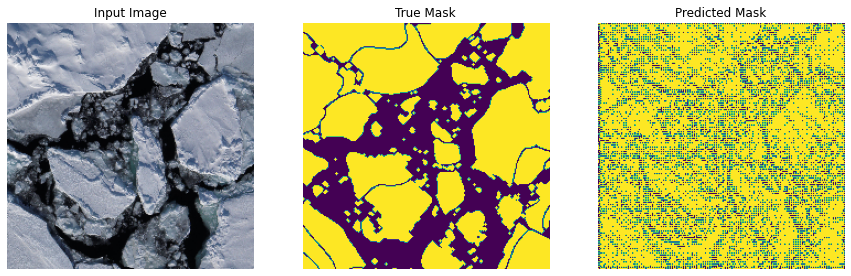

In [44]:
show_predictions()

In [61]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [80]:
EPOCHS = 3

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/3
Tensor("Identity:0", shape=(), dtype=float32) Tensor("Sum_4:0", shape=(), dtype=float32)
Tensor("Identity:0", shape=(), dtype=float32) Tensor("Sum_4:0", shape=(), dtype=float32)
13/81 [===>..........................] - ETA: 3:01 - loss: 0.4796 - accuracy: 0.7722 - true_negative_rate: 2.5918

KeyboardInterrupt: 

Epoch 1/3
1687/1687 [==============================] - 112s 65ms/step - loss: 0.0857 - accuracy: 0.9645 - val_loss: 1.1566 - val_accuracy: 0.8409


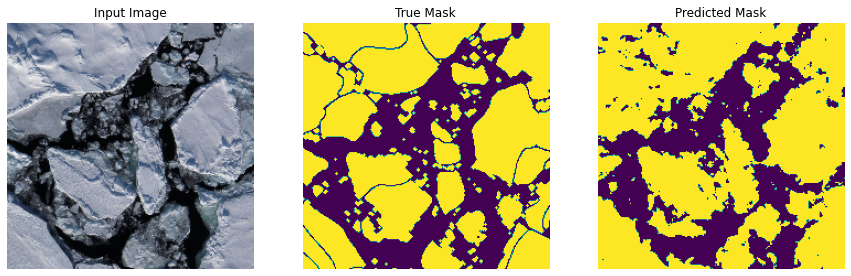


Sample Prediction after epoch 1

Epoch 2/3
1687/1687 [==============================] - 108s 64ms/step - loss: 0.0375 - accuracy: 0.9850 - val_loss: 1.4912 - val_accuracy: 0.8402


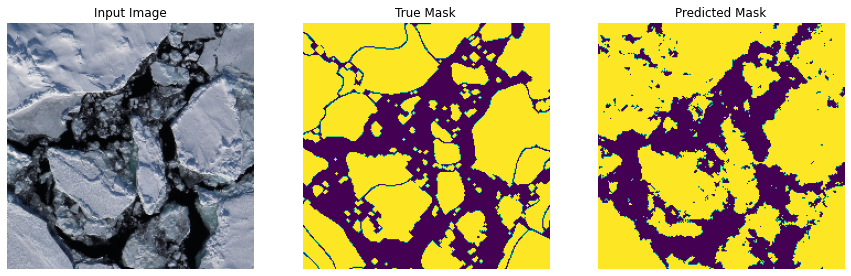


Sample Prediction after epoch 2

Epoch 3/3
1687/1687 [==============================] - 109s 65ms/step - loss: 0.0311 - accuracy: 0.9879 - val_loss: 1.7465 - val_accuracy: 0.8403


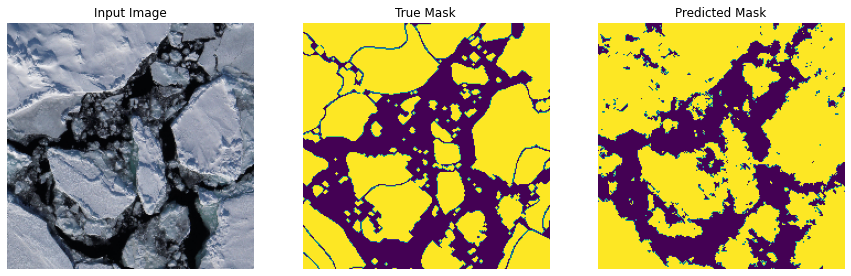


Sample Prediction after epoch 3



In [47]:
EPOCHS = 3

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()])

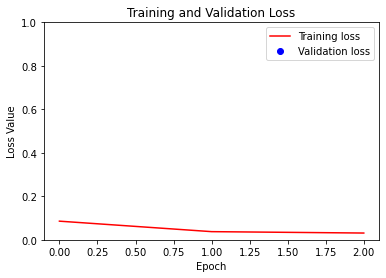

In [48]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [49]:
val_loss

[1.1565799713134766, 1.4912372827529907, 1.7465310096740723]

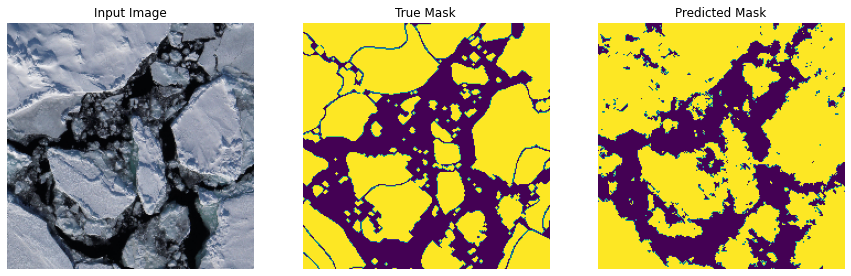

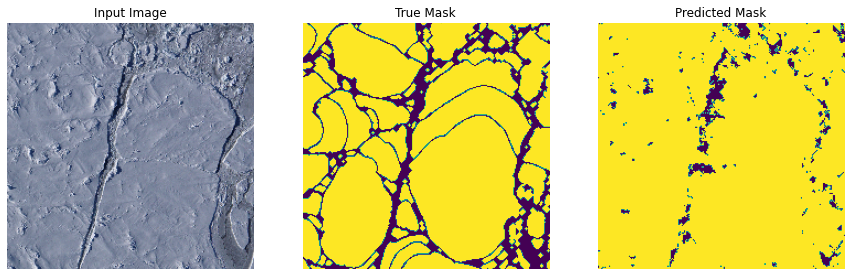

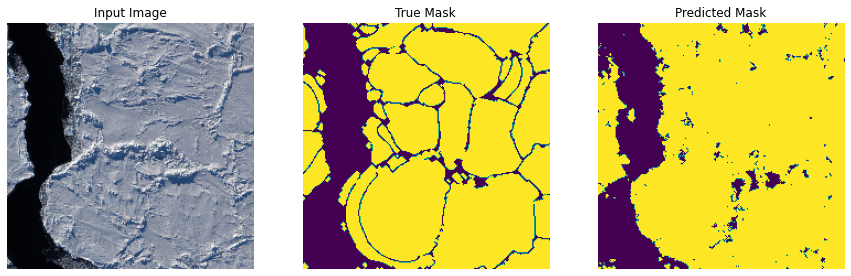

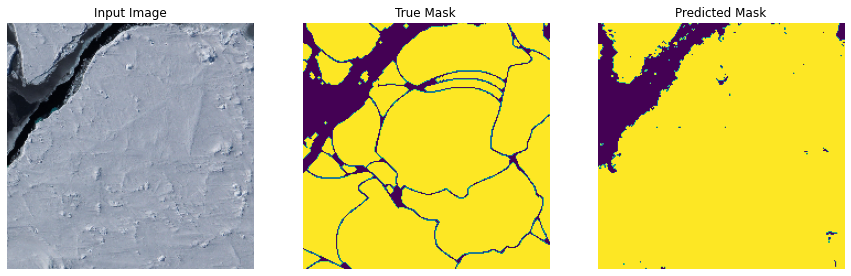

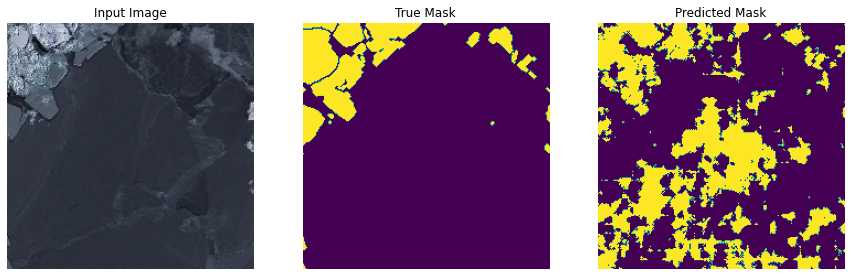

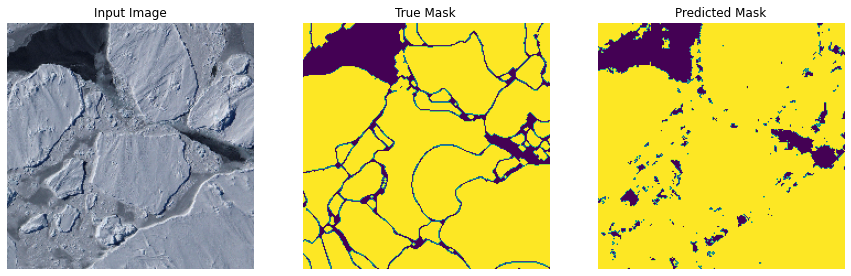

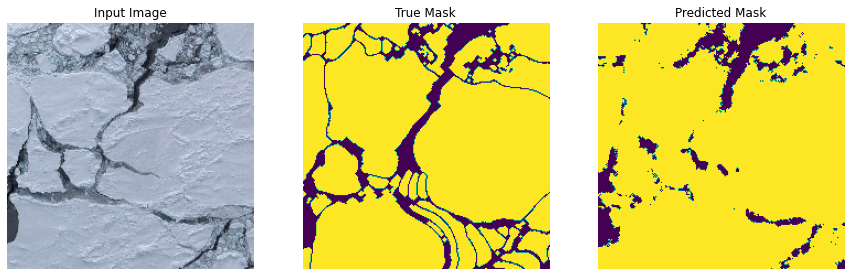

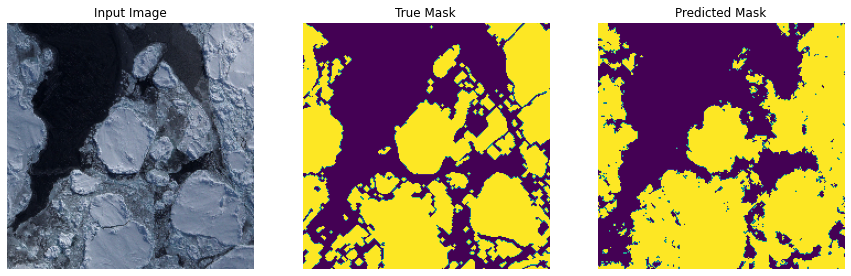

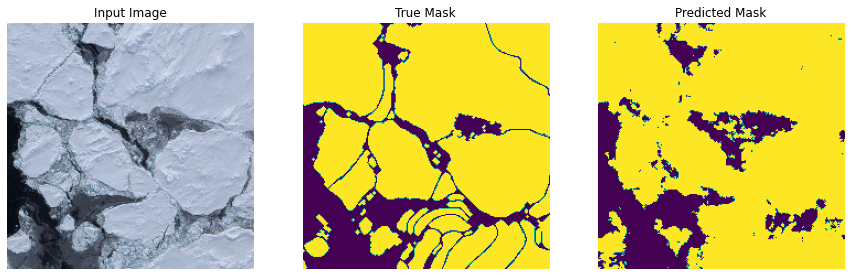

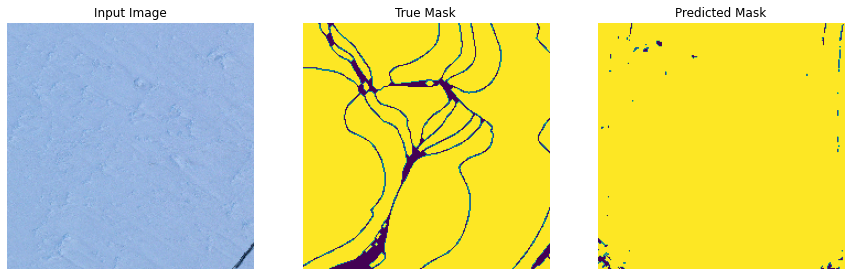

In [51]:
show_predictions(val_dataset, 10)